<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Авторы материала: Data Science интерн Ciklum, студент магистерской программы CSDS UCU Виталий Радченко, аналитик Вымпелком Саян Омаров. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 5
## <center> Логистическая регрессия и случайный лес в задаче кредитного скоринга

#### Нашей главной задачей будет построение модели для задачи кредитного скоринга.

Но для разминки решите первое задание :)

**Задание 1** В зале суда есть 5 присяжных, каждый из них по отдельности с вероятностью 70% может правильно определить виновен подсудимый или нет. С какой вероятностью они все вместе вынесут правильный вердикт, если решение принимается большинством голосов?
- 70.00%
- 83.20%
- 83.70% *right*
- 87.50%

Теперь перейдем непосредственно к машинному обучению.


#### Данные представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	     ----Человек не выплатил данный кредит в течение 90 дней; возможные значения  1/0 

##### Независимые признаки
* age	                         ---- Возраст заёмщика кредитных средств; тип - integer
* NumberOfTime30-59DaysPastDueNotWorse	----Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней, но не больше в течение последних двух лет; тип -	integer
* DebtRatio ----	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип -	real
* MonthlyIncome	----Месячный доход в долларах; тип -	real
* NumberOfTimes90DaysLate ----Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип -	integer
* NumberOfTime60-89DaysPastDueNotWorse----	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней, но не больше в течение последних двух лет; ; тип -	integer
* NumberOfDependents ----Число человек в семье кредитозаёмщика; тип -	integer

In [ ]:
from scipy.special import binom
N = 5
result = 0
p = 0.7
for i in range(3,N+1):
    result+= binom(N,i)*p**i*(1-p)**(N-i)
print(result)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# отключим предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [3]:
## Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы 
def delete_nan(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

In [4]:
## Считываем данные
data = pd.read_csv('../../data/credit_scoring_sample.csv', sep =';')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [5]:
## Рассмотрим типы считанных данных
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

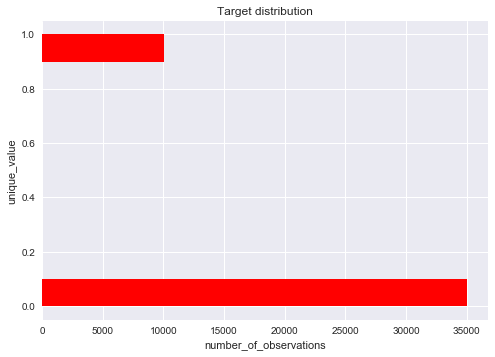

In [6]:
## Посмотрим на распределение классов в зависимой переменной

ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

In [7]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого

#independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names


['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [8]:
## Применяем функцию, заменяющую все NaN значения на медианное значение соответствующего столбца
table = delete_nan(data)
table.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

In [9]:
## Разделяем таргет и признаки 
X =table[independent_columns_names]
y = table['SeriousDlqin2yrs']


# Бутстрэп

**Задание 2.** Сделайте интервальную оценку среднего возраста (age) для клиентов, которые просрочили выплату кредита, с 90% "уверенностью". (используйте пример из статьи. Поставьте np.random.seed(0) как это сделано в статье)

In [10]:
def get_bootstrap_samples(data,n_samples):
    #bootstrapind data, where data - 1D array
    indices = np.random.randint(0,len(data),(n_samples,len(data)))
    bootstraped_data = data[indices]
    return bootstraped_data 
def stat_intervals(data, alpha):
    # interval of alpha % confidence
    interval = np.percentile(data,[100*(1-alpha)/2,100*((1+alpha)/2)])
    return interval


# set seed 
np.random.seed(0)
# select data
ages = data[data['SeriousDlqin2yrs'] == 1].loc[:,'age'].values
#bootstrape data
ages_bootstraped = get_bootstrap_samples(ages, 1000)
# average across bootstraped samples
ages_bootstraped_aver = np.mean(ages_bootstraped, axis = 1)
# calculate stat
conf_interval_90 = stat_intervals(ages_bootstraped_aver,0.9)
print('Mean interval with {} % confidence: {}'.format(90,conf_interval_90))



Mean interval with 90 % confidence: [ 45.71379414  46.12700479]


## Подбор параметров для модели логистической регрессии 

#### Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0  до 1.   Чем ближе начение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Используем модуль LogisticRegression для построения логистической регрессии.
## Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
## Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight= 'balanced')

## Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
## Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны, 
## и будет хорошо предсказывать значения таргета, с другой.
## Остальные параметры оставляем по умолчанию.
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

## Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть 
## значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

**Задание 3.**
Сделайте GridSearch с метрикой "roc-auc" по параметру C. Какое оптимальное значение параметра С?

In [12]:
clf = GridSearchCV(lr, parameters, cv = skf, scoring = 'roc_auc', n_jobs = -1)
clf.fit(X,y)
clf.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=5,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

**Задание 4.** 
Можно ли считать лучшую модель устойчивой? (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%) Сохраните точность лучшей модели, она вам приходится для следующих заданий

In [13]:
best_score = clf.best_score_
print(best_score)
print('Avg std score on validation set {}'.format(clf.cv_results_['std_test_score'].mean()))

0.796020375664
Avg std score on validation set 0.00373072743577


## Определение влияния признаков

**Задание 5.**
Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, что бы можно их было корректно сравнить.

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
lr = LogisticRegression(C=0.001, class_weight='balanced', random_state=5)
lr.fit(scaler.fit_transform(X),y)
feature_importance = pd.DataFrame({'feat': independent_columns_names,'scores': lr.coef_.flatten()}).sort_values('scores',ascending = False)
feature_importance

,feat,scores
1,NumberOfTime30-59DaysPastDueNotWorse,0.724004
3,NumberOfTimes90DaysLate,0.517673
4,NumberOfTime60-89DaysPastDueNotWorse,0.194732
6,NumberOfDependents,0.101326
2,DebtRatio,-0.024082
5,MonthlyIncome,-0.162864
0,age,-0.416304


**Задание 6.** Посчитайте долю влияния `DebtRatio` на предсказание. (Воспользуйтесь функцией [softmax](https://en.wikipedia.org/wiki/Softmax_function))

In [15]:
def softmax(x):
    exp_x = np.exp(x-np.max(x))
    softmax_x = exp_x/sum(exp_x)
    return softmax_x
feature_importance['softmax'] = softmax(feature_importance['scores'])
feature_importance

,feat,scores,softmax
1,NumberOfTime30-59DaysPastDueNotWorse,0.724004,0.241310
3,NumberOfTimes90DaysLate,0.517673,0.196321
4,NumberOfTime60-89DaysPastDueNotWorse,0.194732,0.142140
6,NumberOfDependents,0.101326,0.129464
2,DebtRatio,-0.024082,0.114205
5,MonthlyIncome,-0.162864,0.099406
0,age,-0.416304,0.077152


**Задание 7.** 
Давайте посмотрим как можно интерпретировать влияние наших признаков. Для этого заного оценим логистическую регрессию в абсолютных величинах. После этого посчитайте во сколько раз увеличатся шансы, что клиент не выплатит кредит, если увеличить возраст на 20 лет при всех остальных равных значениях признаков. (теоретический расчет можно посмотреть [здесь](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf))

In [16]:
from sklearn.preprocessing import StandardScaler
lr = LogisticRegression(C=0.001, class_weight='balanced', random_state=5)
lr.fit(X,y)
feature_importance_unscaled = pd.DataFrame({'feat': independent_columns_names,'scores': lr.coef_.flatten()}).sort_values('scores',ascending = False)

# calculate the increase in odds of not returning credit in time obtained by increasing 'age' by 20 = exp(beta_age*delta_age)
beta_age = feature_importance_unscaled[
    feature_importance_unscaled['feat'] == 'age']['scores']
OR = np.exp(beta_age*20)
print(OR)



0    0.695096
Name: scores, dtype: float64


# Случайный лес

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами 
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, oob_score=True, class_weight='balanced')

## Будем искать лучшие параметры среди следующего набора
parameters = {'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5,10,15]}

## Делаем опять же стрэтифайд k-fold валидацию. 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

**Задание 8.** На сколько точность лучшей модели случайного леса выше точности логистической регрессии на валидации?

In [19]:
clf = GridSearchCV(rf, parameters, scoring = 'roc_auc', n_jobs = -1, cv = skf)
clf.fit(X,y)
print(clf.best_estimator_)
print (clf.best_score_)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=2,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=9, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)
0.835407278321


**Задание 9.** Определите какой признак имеет самое слабое влияние.

In [24]:
clf.best_estimator_.feature_importances_.flatten()
feature_importance_rf = pd.DataFrame({'feat': independent_columns_names,'scores': clf.best_estimator_.feature_importances_.flatten()}).sort_values('scores',ascending = True) 
feature_importance_rf


,feat,scores
6,NumberOfDependents,0.014457
5,MonthlyIncome,0.058536
2,DebtRatio,0.076190
0,age,0.116950
4,NumberOfTime60-89DaysPastDueNotWorse,0.153586
3,NumberOfTimes90DaysLate,0.278862
1,NumberOfTime30-59DaysPastDueNotWorse,0.301419


** Задание 10.** Какое наиболее существенное примущество логистической регрессии перед случайным лесом для нашей бизнес-задачи?

- меньше тратится времени для тренировки модели; *right*
- меньше параметров для перебора;
- интепретируемость признаков;
- линейные свойства алгоритма. *right*

# Бэггинг

In [26]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100]}

**Задание 11.** Следующая задача обучить бэггинг классификатор (random_state=42). В качестве базовых классификаторов возьмите 100 логистических регрессий и на этот раз используйте не GridSearchCV, а RandomizedSearchCV. Так как перебирать все 54 варианта комбинаций долго, то поставьте максимальное число итераций 20 для RandomizedSearchCV. Так же не забудьте передать параметр валидации cv и `random_state=1`. Какая лучшая точность получилась?

In [30]:
base_est = LogisticRegression(random_state=5, class_weight= 'balanced')
bag_clf = BaggingClassifier(base_est, n_estimators=100, n_jobs=-1, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
clf = RandomizedSearchCV(bag_clf, parameters, n_iter=54, scoring='roc_auc', n_jobs=-1, cv=skf, random_state=1)
clf.fit(X,y)
print(clf.best_estimator_)
print(clf.best_score_)

BaggingClassifier(base_estimator=LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=5,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=2,
         max_samples=0.9, n_estimators=100, n_jobs=-1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)
0.807737254349


**Задача 12.** Дайте интерпретацию лучших параметров для бэггинга. Почему именно такие значения оказались лучшими?

- для бэггинга важно использовать как можно меньше признаков
- бэггинг лучше работает на небольших выборках
- меньше корреляция между одиночными моделями
- чем больше признаков, тем меньше теряется информации